In [1]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.ml.feature import Word2Vec, Tokenizer, StandardScaler
from pyspark.sql.functions import regexp_replace, lower, col, udf, asc, desc, explode
from pyspark.sql.functions import split, size, array_join
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import re
import spacy
import nltk
from nltk.corpus import stopwords

from datetime import datetime
import matplotlib.pyplot as plt

from gensim import corpora, models
import numpy as np

from operator import contains
from wordcloud import WordCloud, STOPWORDS

# Needed on RaaS
os.environ['PYSPARK_PYTHON'] = sys.executable

# Not needed
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# cred ca vrea sa fie rulat totusi

In [2]:
PATH = '/home/ubuntu/data/arxiv.json'

In [3]:
def init_spark():
  spark = SparkSession.builder.config("spark.driver.memory", "5g").\
                              appName("BigData").getOrCreate()
  
  sc = spark.sparkContext
  return spark, sc

## **Preprocess dataset for training and testing.**

In [4]:
def get_sample_from_file(file_name, output_file, sample_size = 10_000):
    """
    Reads a file and extracts a sample of lines from it.
    
    Parameters:
    file_name (str): The name of the input file.
    output_file (str): The name of the output file where the sample will be written.
    sample_size (int): The number of lines to extract from the input file. Default is 10,000.
    """
    
    content = ""
    with open(file_name, "r") as f:
        for i in range(sample_size):
            content += f.readline()

    with open(output_file, "w") as f:
        f.write(content)

In [5]:
def load_data_from_json(spark, file_name):
    return spark.read.json(file_name)

### Initialize Context and Load Sample

In [6]:
sc = init_spark()[0]
arxiv_dataset = load_data_from_json(sc, PATH)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/18 20:34:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## **Clean dataset**

### Searcing for missing values

In [8]:
# search for missing values
print("Number of missing values in abstract column: ", arxiv_dataset.filter(arxiv_dataset.abstract.isNull()).count())
print("Number of missing values in title column: ", arxiv_dataset.filter(arxiv_dataset.title.isNull()).count())
print("Number of missing values in categories column: ", arxiv_dataset.filter(arxiv_dataset.categories.isNull()).count())
print("Number of missing values in id column: ", arxiv_dataset.filter(arxiv_dataset.id.isNull()).count())
print("Number of missing values in submitter column: ", arxiv_dataset.filter(arxiv_dataset.submitter.isNull()).count())
print("Number of missing values in authors column: ", arxiv_dataset.filter(arxiv_dataset.authors.isNull()).count())
print("Number of missing values in report-no column: ",arxiv_dataset.filter(arxiv_dataset["report-no"].isNull()).count() )
print("Number of missing values in comments column: ", arxiv_dataset.filter(arxiv_dataset.comments.isNull()).count())
print("Number of missing values in doi column: ", arxiv_dataset.filter(arxiv_dataset.doi.isNull()).count())
print("Number of missing values in journal-ref column: ", arxiv_dataset.filter(arxiv_dataset["journal-ref"].isNull()).count())
print("Number of missing values in versions column: ", arxiv_dataset.filter(arxiv_dataset.versions.isNull()).count())


Number of missing values in abstract column:  0


Number of missing values in title column:  0


Number of missing values in categories column:  0


Number of missing values in id column:  0


Number of missing values in submitter column:  15189


Number of missing values in authors column:  0


Number of missing values in report-no column:  2221106


Number of missing values in comments column:  580509


Number of missing values in doi column:  1240532


Number of missing values in journal-ref column:  1570791


Number of missing values in versions column:  0


In [9]:
# show rows with empty fields
empty_abstract = arxiv_dataset.filter(arxiv_dataset["abstract"] == "").count()
empty_title = arxiv_dataset.filter(arxiv_dataset["title"] == "").count()
empty_authors = arxiv_dataset.filter(arxiv_dataset["authors"] == "").count()
empty_categories = arxiv_dataset.filter(arxiv_dataset["categories"] == "").count()

In [10]:
print(empty_abstract)
print(empty_title)
print(empty_authors)
print(empty_categories)

0
0
0
0


### **Basic preprocessing functions**

In [7]:
# fill ALL NULL values with empty string : use after removing rows with empty fields
def fill_na_with_empty_string(df):
    return df.fillna("")

# remove rows with empty fields
def remove_empty_fields(df, field_name):
    return df.filter(df[field_name] != "")

# remove "\n" from text
def remove_empty_newlines(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\n", " "))

# remove math formulas and latex
def remove_math_formula(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\$.*?\$", ""))

# convert to lowercase
def convert_to_lowercase(df, field_name):
    return df.withColumn(field_name, lower(col(field_name)))

# remove extra spaces
def remove_extra_spaces(df, field_name):
    df = df.withColumn(field_name, regexp_replace(col(field_name), " +", " "))
    df = df.withColumn(field_name, regexp_replace(col(field_name), "^ +", ""))
    return df

def remove_punctuation_except_dot(df, field_name):
    pattern = "[^a-zA-Z0-9\s\.,]"
    cleaned_df = df.withColumn(field_name, regexp_replace(col(field_name), pattern, ""))
    return cleaned_df

# remove punctuation
def remove_punctuation(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "[^\w\s]", ""))

def remove_text_in_braces(df, field_name):
    pattern = r'[\(\{\[].*?[\)\}\]]'
    cleaned_df = df.withColumn(field_name, regexp_replace(col(field_name), pattern, ''))
    return cleaned_df

def remove_text_between_parentheses(strings_list):
    result_list = []
    for string in strings_list:
        modified_string = re.sub(r'\([^()]*\)', '', string)
        result_list.append(modified_string)
    return result_list

def remove_substring_from_list(input_list, substring_to_remove):
    return [element.replace(substring_to_remove, "") for element in input_list]

def remove_stop_words(df, field_name, output_field, stop_words):
  df = df.withColumn("tokens", split(field_name, "\\s+"))
  remover = StopWordsRemover(stopWords=stop_words, inputCol="tokens", outputCol=output_field)
  return remover.transform(df).select(field_name, "categories", array_join(output_field, " ").alias(output_field))

def split_function(sep, authors_list):
  for i in range(len(authors_list)):
      element = authors_list[i]
      author = element.split(sep)
      authors_list[i] = author
  authors_list = set([item for sublist in authors_list for item in sublist])
  return list(authors_list)

def delete_new_line_and_spaces(author_list):
  for i in range(len(author_list)):
    if author_list[i].startswith("\n "):
      author_list[i] = author_list[i].replace("\n ", '', 1)
  for i in range(len(author_list)):
    author_list[i] = author_list[i].strip()
  for author in author_list:
    if author == '':
      author_list.remove(author)
  return author_list

def delete_duplicate(author_list):
  distinct_list = []
  for author in author_list:
    if author not in distinct_list:
      distinct_list.append(author)
  return distinct_list

def delete_letter(author_list):
  for author in author_list:
    if len(author) == 1:
      author_list.remove(author)
    elif len(author) == 2 and author[-1] == ".":
      author_list.remove(author)
  return author_list

def remove_characters_before_substring(original_list, target_substring):
    return [remove_characters(element, target_substring) for element in original_list]

def remove_characters(original_string, target_substring):
    index = original_string.lower().find(target_substring.lower())
    if index != -1:
        return original_string[index + len(target_substring):]
    else:
        return original_string

def delete_element(input_list, substr):
  for element in input_list:
    if substr.lower() in element.lower():
      input_list.remove(element)
  return input_list


### Clear 'abstract' column

In [12]:
arxiv_dataset = remove_empty_fields(arxiv_dataset, "abstract")
arxiv_dataset = remove_empty_newlines(arxiv_dataset, "abstract")
arxiv_dataset = remove_math_formula(arxiv_dataset, "abstract")
arxiv_dataset = convert_to_lowercase(arxiv_dataset, "abstract")
arxiv_dataset = remove_extra_spaces(arxiv_dataset, "abstract")

In [13]:
# Show some changed rows
arxiv_dataset.select("abstract").show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|abstract       

## Convert Abstract to Vector Representation

In [ ]:
# create a Word2Vec model
input_col = "abstract"
output_col = "abstract_vector"

words2vec_model = Word2Vec(
    inputCol="words",
    outputCol=output_col,
    vectorSize=100,
    minCount=5
)

tokenized = Tokenizer(inputCol=input_col, outputCol="words")
tokenized_dataset = tokenized.transform(arxiv_dataset)
model = words2vec_model.fit(tokenized_dataset)

In [ ]:
model.getVectors().show(n=2, truncate=False)

### **Vizualize most popular categories based on how many authors contributed to that category**

In [8]:
@udf(returnType=ArrayType(StringType()))
def get_authors_list(parsed_authors):
    authors = [
        f"{author[0]} {author[1]}" for author in parsed_authors
    ]
    return authors

In [15]:
arxiv_dataset = arxiv_dataset.withColumn("authors_list", get_authors_list("authors_parsed"))

In [17]:
arxiv_dataset.select("authors_list").show(5, truncate=False)

+------------------------------------------------------+
|authors_list                                          |
+------------------------------------------------------+
|[Balázs C., Berger E. L., Nadolsky P. M., Yuan C. -P.]|
|[Streinu Ileana, Theran Louis]                        |
|[Pan Hongjun]                                         |
|[Callan David]                                        |
|[Abu-Shammala Wael, Torchinsky Alberto]               |
+------------------------------------------------------+
only showing top 5 rows



In [18]:
# preprocess authors column : remove the "and" word and split the authors by comma
def preprocess_authors(df):
    return df.withColumn("authors", regexp_replace(col("authors"), " and ", ", "))

# preprocess authors column : remove extra commas
def remove_authors_extra_commas(df):
    return df.withColumn("authors", regexp_replace(col("authors"), ",+", ","))
    
# preprocess authors column : remove empty spaces (more than one space)
def remove_authors_extra_spaces(df):
    return df.withColumn("authors", regexp_replace(col("authors"), " +", " "))

# preprocess authors column : remove parentheses and their content
def remove_authors_parentheses(df):
    return df.withColumn("authors", regexp_replace(col("authors"), "\(.+?\)", ""))
    

In [19]:
arxiv_dataset = preprocess_authors(arxiv_dataset)
arxiv_dataset = remove_authors_extra_commas(arxiv_dataset)
arxiv_dataset = remove_authors_extra_spaces(arxiv_dataset)

In [20]:
# see the first 5 rows
arxiv_dataset.select("authors_list").show(5, truncate=False)

+------------------------------------------------------+
|authors_list                                          |
+------------------------------------------------------+
|[Balázs C., Berger E. L., Nadolsky P. M., Yuan C. -P.]|
|[Streinu Ileana, Theran Louis]                        |
|[Pan Hongjun]                                         |
|[Callan David]                                        |
|[Abu-Shammala Wael, Torchinsky Alberto]               |
+------------------------------------------------------+
only showing top 5 rows



In [21]:
# Get all categories
categories = arxiv_dataset.select("categories")

categories = (
    categories.rdd.map(lambda x: x.categories)
    .map(lambda x: x.split(" "))
    .map(lambda x: [item for item in x])
    .flatMap(lambda x: x)
    .distinct()
)

print("Number of categories: ", categories.count())

# Get all authors
authors = arxiv_dataset.select("authors_list")
authors = (
    authors.rdd.map(lambda x: x.authors_list)
    .map(lambda x: [item for item in x])
    .flatMap(lambda x: x)
    .distinct()
)

print("Number of authors: ", authors.count())

# get all authors for each category

categories_authors = {}
auth_categories = arxiv_dataset.select("categories", "authors_list")
categories_authors = (
    auth_categories.rdd.map(lambda x: (x.categories, x.authors_list))
    .map(lambda x: (x[0].split(" "), x[1]))
    .flatMap(lambda x: [(item, x[1]) for item in x[0]])
    .reduceByKey(lambda x, y: x + y)
    .map(lambda x: (x[0], list(set(x[1]))))
)

# categories_authors to dict
categories_authors = dict(categories_authors.collect())

# get number of authors for each category
count_authors = {}
for category in categories_authors:
    count_authors[category] = len(categories_authors[category])

# sort categories based on number of authors
sorted_categories = sorted(count_authors.items(), key=lambda x: x[1], reverse=True)

# get top 10 categories
top_categories = sorted_categories[:10]

Number of categories:  176


Number of authors:  1568947


In [22]:
top_categories

[('cs.LG', 222982),
 ('cond-mat.mtrl-sci', 166747),
 ('cs.CV', 157651),
 ('cs.AI', 143642),
 ('quant-ph', 117660),
 ('cond-mat.mes-hall', 116305),
 ('astro-ph.IM', 107898),
 ('hep-ph', 101636),
 ('physics.ins-det', 98432),
 ('hep-ex', 95385)]

### **Topic extraction and stats (most popular topic per category)**

In [ ]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, PATH)

In [7]:
# https://arxiv.org/help/api/user-manual
category_map = {'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'}

#### **Display the distribution of categories**
- the categories are mostly 1 to 2 per paper

In [8]:
categories_length = arxiv_dataset.select(size(split(arxiv_dataset.categories, " ")).alias("categories_length"))

In [9]:
# print max, min, and average number of categories
maxim = categories_length.agg({"categories_length": "max"}).collect()[0][0]
minim = categories_length.agg({"categories_length": "min"}).collect()[0][0]
avg = categories_length.agg({"categories_length": "mean"}).collect()[0][0]
std = categories_length.agg({"categories_length": "std"}).collect()[0][0]
median = categories_length.agg({"categories_length": "median"}).collect()[0][0]

print("Max number of categories: ", maxim)
print("Min number of categories: ", minim)
print("Average number of categories: ", avg)
print("Standard deviation of categories: ", std)
print("Median number of categories: ", median)

Max number of categories:  13
Min number of categories:  1
Average number of categories:  1.6957565665834098
Standard deviation of categories:  0.9250407314885232
Median number of categories:  1.0


(array([1.29308e+06, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 7.05024e+05, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.79714e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        9.03560e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.52430e+04, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 5.38900e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        8.02000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.45000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 3.20000e+01, 0.00000e+00, 0.00

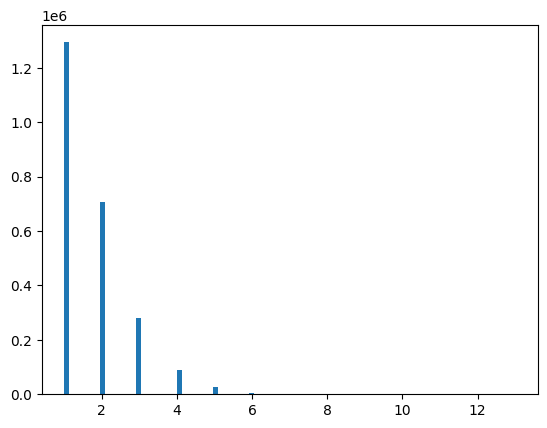

In [10]:
categories_length_list  = map(lambda row: row.categories_length, categories_length.collect())
plt.hist(list(categories_length_list), bins=100)

#### **Most/Least popular category**

----------------------------------------                                        
Exception occurred during processing of request from ('127.0.0.1', 56942)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/ubuntu/jupyter/BDA/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/home/ubuntu/jupyter/BDA/lib/python3.10/site-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/home/ubuntu/jupyter/BDA/lib/python3.10/site-package

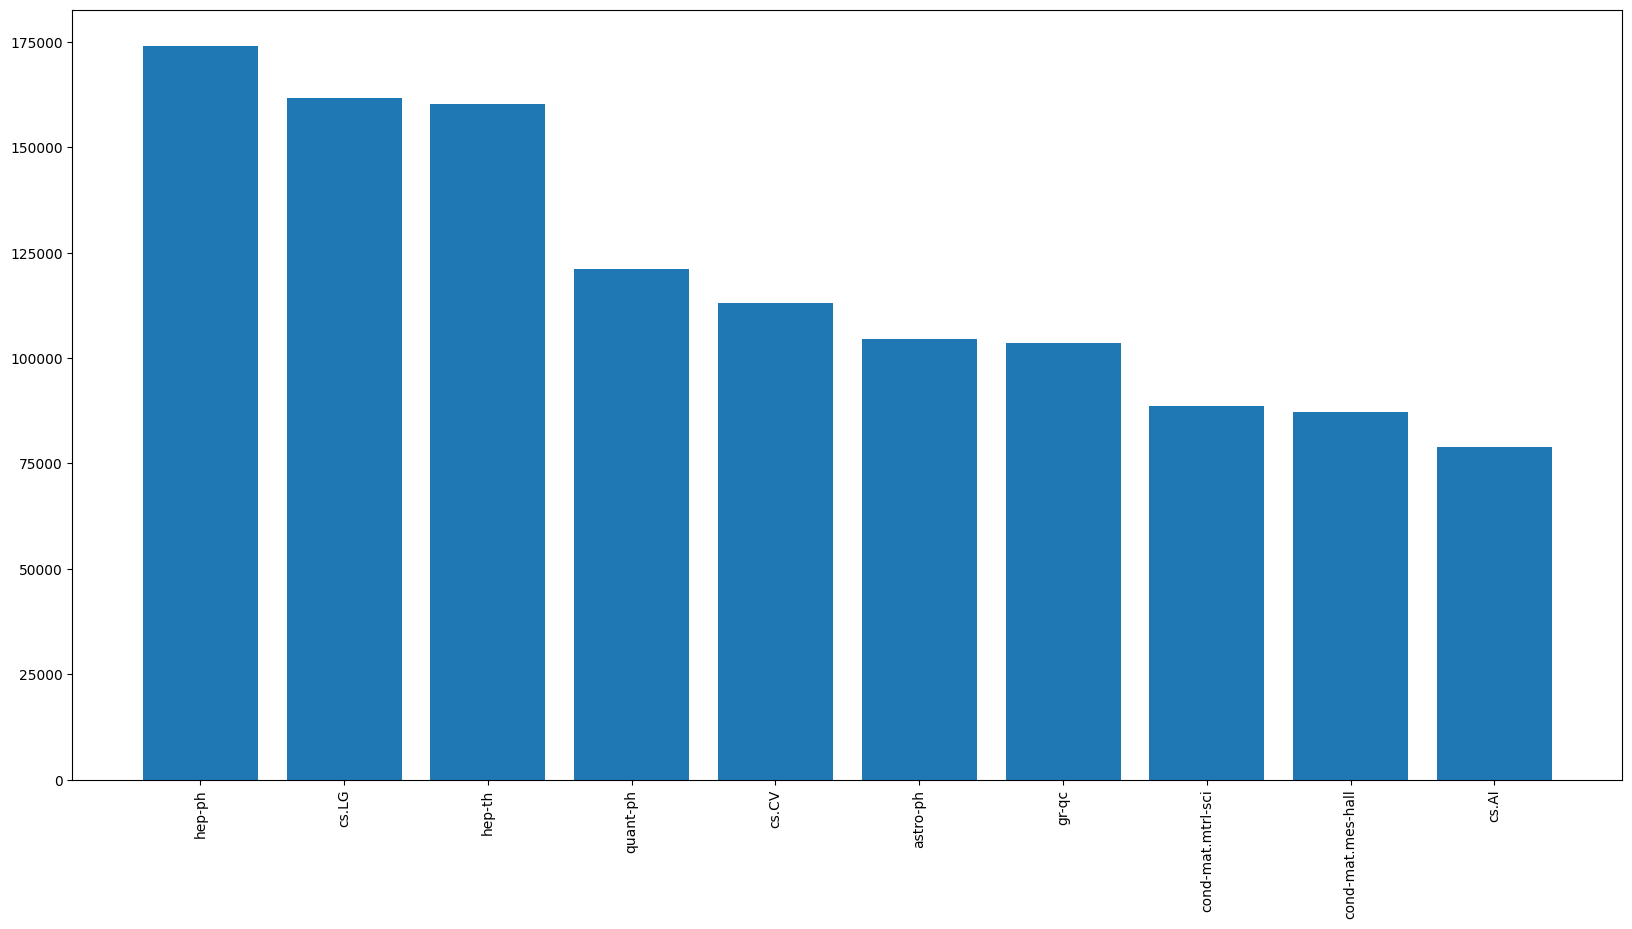

In [9]:
categories = arxiv_dataset.select("categories")
categories = (
    categories.rdd.map(lambda x: x.categories)
    .map(lambda x: x.split(" "))
    .map(lambda x: [item for item in x])
    .flatMap(lambda x: x)
    .distinct()
)

# get most frequent categories
categories_count = {}
for category in categories.collect():
    categories_count[category] = 0

for row in arxiv_dataset.select("categories").collect():
    for category in row.categories.split(" "):
        categories_count[category] += 1

sorted_categories = sorted(categories_count.items(), key=lambda x: x[1], reverse=True)
top_categories = sorted_categories[:10]

# plot the top 10 categories
plt.figure(figsize=(20, 10))
plt.bar(*zip(*top_categories))
plt.xticks(rotation=90)
plt.show()


#### Analyzing the abstracts

In [8]:
# abstract length (histogram)
abstract_lengths = arxiv_dataset.select(size(split("abstract", " ")).alias('abstract_lengths'))

In [9]:
max_length = abstract_lengths.agg({"abstract_lengths": "max"}).collect()[0][0]
min_length = abstract_lengths.agg({"abstract_lengths": "min"}).collect()[0][0]
avg_length = abstract_lengths.agg({"abstract_lengths": "mean"}).collect()[0][0]
std_length = abstract_lengths.agg({"abstract_lengths": "std"}).collect()[0][0]
median_length = abstract_lengths.agg({"abstract_lengths": "median"}).collect()[0][0]

# In number of words
print("Max length of abstract: ", max_length)
print("Min length of abstract: ", min_length)
print("Average length of abstract: ", avg_length)
print("Standard deviation of abstract length: ", std_length)
print("Median length of abstract: ", median_length)

Max length of abstract:  848
Min length of abstract:  3
Average length of abstract:  130.2041826784043
Standard deviation of abstract length:  58.3419904624102
Median length of abstract:  125.0


(array([1.64200e+03, 1.09600e+04, 2.71470e+04, 3.69570e+04, 5.75880e+04,
        6.63800e+04, 9.14420e+04, 9.46590e+04, 1.22099e+05, 1.18774e+05,
        1.25141e+05, 1.38633e+05, 1.23087e+05, 1.37256e+05, 1.18649e+05,
        1.37730e+05, 1.12821e+05, 1.14618e+05, 9.35450e+04, 8.65270e+04,
        9.11590e+04, 7.88530e+04, 6.83560e+04, 5.31330e+04, 5.33730e+04,
        4.42540e+04, 5.44370e+04, 3.63670e+04, 3.18680e+04, 2.36550e+04,
        1.87450e+04, 1.46410e+04, 8.05000e+03, 4.44300e+03, 1.56100e+03,
        6.43000e+02, 2.16000e+02, 8.80000e+01, 4.60000e+01, 3.80000e+01,
        3.20000e+01, 1.70000e+01, 2.60000e+01, 1.70000e+01, 2.20000e+01,
        1.20000e+01, 1.50000e+01, 9.00000e+00, 1.00000e+01, 8.00000e+00,
        7.00000e+00, 4.00000e+00, 9.00000e+00, 5.00000e+00, 9.00000e+00,
        2.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00

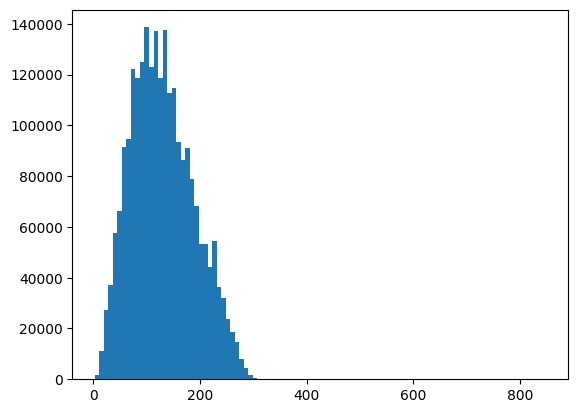

In [10]:
abstract_lengths_list = map(lambda row: row.abstract_lengths, abstract_lengths.collect())

plt.hist(list(abstract_lengths_list), bins=100)

### **LDA preparations**

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# after some research : spacy is a bit faster than nltk on large datasets
def lemmatization(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in text.split(" ")])

In [7]:
nlp = spacy.load('en_core_web_sm')

In [18]:
@udf(returnType=StringType())
def lemmatization_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [19]:
@udf(returnType=StringType())
def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

In [31]:
@udf(returnType=StringType())
def remove_punctuation_udf(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_punct])

In [34]:
@udf(returnType=StringType())
def convert_to_lowercase(text):
    return text.lower()

In [23]:
get_sample_from_file(PATH+"/arxiv-metadata-oai-snapshot.json", "/home/ubuntu/data/arxiv-sample.json", sample_size = 100_000)

In [12]:
arxiv_dataset = load_data_from_json(sc, "/home/ubuntu/data/arxiv-sample.json")

In [35]:
# clear abstract column
arxiv_dataset = remove_empty_fields(arxiv_dataset, "abstract")
arxiv_dataset = remove_empty_newlines(arxiv_dataset, "abstract")
arxiv_dataset = remove_math_formula(arxiv_dataset, "abstract")
arxiv_dataset = remove_extra_spaces(arxiv_dataset, "abstract")
arxiv_dataset = remove_punctuation(arxiv_dataset, "abstract")

# convert to lowercase
arxiv_dataset = arxiv_dataset.withColumn("abstract", convert_to_lowercase("abstract"))
# remove punctuation
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_punctuation_udf("abstract"))
# remove stopwords
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_stopwords("abstract"))

In [36]:
arxiv_dataset = arxiv_dataset.withColumn("abstract", lemmatization_spacy("abstract"))

### **Gensim**

In [37]:
abstracts = arxiv_dataset.select("abstract").rdd.map(lambda x: x.abstract.split()).collect()

In [38]:
dictionary = corpora.Dictionary(abstracts)
dictionary.filter_extremes(no_below=20, no_above=0.05)

In [39]:
dictionary.most_common(5)

[('cluster', 1335),
 ('hole', 1011),
 ('network', 974),
 ('velocity', 879),
 ('frequency', 843)]

In [41]:
corpus = [dictionary.doc2bow(text) for text in abstracts]

In [42]:
lda_model = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42, passes=100)

In [43]:
lda_model.print_topics()

[(0,
  '0.016*"lattice" + 0.011*"critical" + 0.010*"charge" + 0.009*"chain" + 0.008*"band" + 0.008*"gap" + 0.008*"pair" + 0.006*"dependence" + 0.006*"electronic" + 0.006*"regime"'),
 (1,
  '0.016*"algebra" + 0.012*"representation" + 0.011*"product" + 0.010*"invariant" + 0.010*"operator" + 0.009*"lie" + 0.009*"manifold" + 0.009*"let" + 0.008*"g" + 0.008*"algebras"'),
 (2,
  '0.011*"boundary" + 0.011*"operator" + 0.010*"metric" + 0.010*"matrix" + 0.010*"entropy" + 0.009*"random" + 0.008*"generalize" + 0.008*"law" + 0.008*"curvature" + 0.007*"asymptotic"'),
 (3,
  '0.019*"quark" + 0.015*"scatter" + 0.013*"production" + 0.013*"cross" + 0.011*"section" + 0.011*"collision" + 0.010*"nuclear" + 0.010*"heavy" + 0.009*"proton" + 0.009*"meson"'),
 (4,
  '0.013*"frequency" + 0.011*"gamma" + 0.010*"signal" + 0.009*"neutrino" + 0.009*"detector" + 0.009*"cosmic" + 0.008*"physics" + 0.007*"noise" + 0.007*"flux" + 0.007*"test"'),
 (5,
  '0.019*"gauge" + 0.016*"black" + 0.016*"hole" + 0.014*"matter" + 0

In [44]:
topics = [
    lda_model.get_document_topics(c)
    for c in corpus
]

In [45]:
topics[1]

[(9, 0.9769116)]

In [46]:
def most_probable_topic(t):
    t = np.array(t)
    idx = t[:, 1].argmax()
    return int(t[idx, 0])

final_topics = [most_probable_topic(t) for t in topics]

### **Query for similar articles (based on the same topic/category/common authors/other criteria)**

In [8]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "/home/ubuntu/data/arxiv-sample.json")

In [9]:
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
words_data = tokenizer.transform(arxiv_dataset)

In [10]:
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashing_tf.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)

In [11]:
# Calculate TF-IDF similarity between articles
article_id = "0704.0001"  # Example article ID
article_tfidf = tfidf_data.filter(col("id") == article_id).select("features").first()["features"]
article_tfidf

SparseVector(1000, {9: 2.7937, 17: 0.1745, 22: 1.9864, 26: 3.0387, 63: 4.6255, 69: 2.9413, 80: 4.7787, 92: 2.7616, 113: 2.8185, 115: 2.8933, 133: 0.9823, 134: 9.6271, 147: 2.7505, 157: 1.527, 159: 2.593, 161: 2.8578, 162: 4.097, 168: 2.3882, 179: 2.0085, 188: 4.8346, 209: 1.1261, 226: 3.4398, 235: 2.0198, 253: 2.1638, 280: 2.7474, 282: 2.2673, 283: 3.0019, 289: 1.8503, 290: 3.0513, 304: 1.4913, 307: 1.8166, 311: 3.5864, 333: 1.7965, 335: 2.5971, 344: 1.4661, 351: 2.917, 353: 2.2799, 372: 0.0, 406: 2.1262, 413: 2.5171, 436: 3.2016, 439: 2.9115, 462: 3.4803, 467: 0.2604, 488: 0.1973, 490: 2.3158, 495: 0.1853, 510: 1.7893, 514: 3.2165, 535: 5.366, 575: 3.2755, 578: 2.6382, 591: 2.2037, 629: 2.01, 646: 3.6345, 650: 1.7756, 652: 3.1943, 653: 2.7521, 662: 2.8987, 663: 0.2806, 675: 3.51, 687: 3.2417, 695: 1.7255, 697: 2.7888, 718: 1.9612, 749: 1.7248, 759: 2.6354, 760: 0.4503, 763: 2.4644, 770: 2.223, 797: 2.9879, 804: 0.9008, 842: 3.1537, 843: 2.8631, 850: 2.9152, 855: 0.8729, 863: 3.3815, 8

In [12]:
article_id2 = "0704.0002"  # Example article ID
article_tfidf2 = tfidf_data.filter(col("id") == article_id2).select("features").first()["features"]
article_tfidf2

SparseVector(1000, {17: 0.0872, 24: 3.2041, 25: 2.8897, 55: 4.2258, 60: 1.5513, 85: 2.4397, 93: 3.5615, 125: 2.3817, 130: 1.4989, 133: 0.9823, 144: 3.316, 165: 2.5873, 181: 2.8613, 182: 2.408, 201: 5.2988, 212: 3.2417, 216: 2.8018, 221: 4.5116, 228: 1.9893, 241: 2.6942, 259: 3.142, 272: 1.3912, 274: 1.8031, 290: 6.1027, 296: 2.1708, 297: 5.834, 299: 1.5631, 310: 5.0946, 346: 2.6326, 372: 0.0, 377: 2.9376, 394: 2.1577, 425: 3.0945, 467: 0.651, 468: 1.5646, 488: 0.1973, 492: 2.6508, 495: 0.1853, 521: 2.616, 527: 2.1346, 581: 0.6502, 585: 5.6777, 588: 0.5146, 591: 2.2037, 601: 3.693, 613: 2.947, 636: 3.734, 650: 0.8878, 663: 0.4208, 686: 1.1935, 705: 3.2265, 719: 6.4886, 736: 0.6273, 760: 0.4503, 783: 2.0876, 784: 3.3525, 785: 3.1056, 791: 3.1034, 792: 2.3744, 828: 2.564, 846: 2.906, 870: 2.8185, 871: 2.144, 884: 3.0858, 885: 2.1355, 889: 1.8252, 891: 1.0487, 904: 3.8267, 935: 2.6839, 971: 8.3996, 975: 8.6475, 982: 3.51, 987: 3.1191})

In [13]:
def cosine_similarity(a, b):
    return float(a.dot(b) / (a.norm(2) * b.norm(2)))

In [14]:
# calculate cosine similarity between article_id and other articles and sort them
similarity = tfidf_data.rdd.map(lambda x: (x.id, cosine_similarity(article_tfidf, x.features))).sortBy(lambda x: x[1], ascending=False)

In [15]:
similarity.take(10)

[('0704.0001', 0.9999999999999999),
 ('0705.0035', 0.3158517952866129),
 ('0706.0518', 0.27351676851108747),
 ('0704.1344', 0.25314024097273047),
 ('0705.3887', 0.24939255602324506),
 ('0704.1677', 0.24928594693946296),
 ('0705.2759', 0.2389668543153525),
 ('0705.1622', 0.2381125997976095),
 ('0705.3836', 0.23796792259432678),
 ('0704.0601', 0.2320099196850292)]

In [16]:
# take the second article from similarity list
article_id2 = similarity.take(2)[1][0]
article_id2

'0705.0035'

In [17]:
# get the information of the second article
arxiv_dataset.filter(arxiv_dataset.id == article_id2).select("title", "abstract", "authors", "categories").show(truncate=False)

+---------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------

In [18]:
# get the information of the first article
arxiv_dataset.filter(arxiv_dataset.id == article_id).select("title", "abstract", "authors", "categories").show(truncate=False)

+----------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Query for similar articles based on category**

In [19]:
### Similar article based on category
def get_similar_articles_by_category(article_id):
    # iterate over all articles 
    categories_search = (
        arxiv_dataset.filter(arxiv_dataset.id == article_id)
        .select("categories")
        .rdd.map(lambda x: x.categories)
        .map(lambda x: x.split(" "))
        .map(lambda x: [item for item in x])
        .flatMap(lambda x: x)
        .collect()
    )
    include_all = len(categories_search)
    if include_all == 0: # invalid article id
        return []
    similar_categories = (
        arxiv_dataset.rdd.map(lambda x: (x.id, x.categories))
        .map(lambda x: (x[0], x[1].split(" ")))
        .filter(lambda x: len(list(value for value in x[1] if value in categories_search)) == include_all)
        .map(lambda x: x[0])
        .filter(lambda x: x != article_id)
        .collect()
    )
    return similar_categories

# get a random article from the list
article_ = arxiv_dataset.rdd.takeSample(False, 1)[0]
# show the article category
print("categories to search after:",  article_.categories)
similar_articles = get_similar_articles_by_category(article_.id)
if len(similar_articles) > 0:
    test_id = similar_articles[0]
    arxiv_dataset.filter(arxiv_dataset.id == test_id).select("title", "abstract", "authors", "categories").show(truncate=False)


categories to search after: cond-mat.str-el
+---------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Query for similar articles based on common authors**

In [20]:
def get_similar_articles_by_common_authors(article_id):
    # get list of authors for the article
    authors_search = (
        arxiv_dataset.filter(arxiv_dataset.id == article_id)
        .select("authors_list")
        .rdd.map(lambda x: x.authors_list)
        .map(lambda x: [item for item in x])
        .flatMap(lambda x: x)
        .collect()
    )
    similar_authors = (
        arxiv_dataset.rdd.map(lambda x: (x.id, x.authors_list))
        .map(lambda x: (x[0], x[1]))
        .filter(lambda x: len(list(value for value in x[1] if value in authors_search)) > 0)
        .map(lambda x: x[0])
        .filter(lambda x: x != article_id)
        .collect()
    )
    return similar_authors

In [23]:
# preprocess dataset authors column
arxiv_dataset = arxiv_dataset.withColumn("authors_list", get_authors_list("authors_parsed"))

In [24]:
# get a random article from the list
article_ = arxiv_dataset.rdd.takeSample(False, 1)[0]

authors_to_search = article_.authors_list

print("authors to search after:", authors_to_search)
similar_articles = get_similar_articles_by_common_authors(article_.id)

if len(similar_articles) > 0:
    test_id = similar_articles[0]
    arxiv_dataset.filter(arxiv_dataset.id == test_id).select("title", "abstract", "authors", "categories").show(truncate=False)


authors to search after: ['Lim May', 'Braha Dan', 'Wijesinghe Sanith', 'Tucker Stephenson', 'Bar-Yam Yaneer']


+-----------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **Classification (for a new article to determine its category)**

### First approach:
- use TF-IDF to vectorize the abstracts and Tokeniezer to tokenize the abstracts
- use CountVectors ("document-term vectors") and regex tokenizer to tokenize the abstracts ( + remove stop words)

Models to use:
- Naive Bayes
- Logistic Regression
- Random Forest

Finally: use Cross-Validation -> try to tune the hyperparameters

In [8]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "/home/ubuntu/data/arxiv-sample.json")

In [9]:
# drop columns
drop_colums = ["authors_parsed", "authors_list", "comments", "doi", "journal-ref", "license", "report-no", "submitter", "title", "versions", "authors", "update_date"]
arxiv_dataset = arxiv_dataset.drop(*drop_colums)

In [10]:
arxiv_dataset.show(5)

+--------------------+---------------+---------+
|            abstract|     categories|       id|
+--------------------+---------------+---------+
|  A fully differe...|         hep-ph|0704.0001|
|  We describe a n...|  math.CO cs.CG|0704.0002|
|  The evolution o...| physics.gen-ph|0704.0003|
|  We show that a ...|        math.CO|0704.0004|
|  In this paper w...|math.CA math.FA|0704.0005|
+--------------------+---------------+---------+
only showing top 5 rows



In [11]:
# from the categories column, get the first category
arxiv_dataset = arxiv_dataset.withColumn("category", split("categories", " ")[0])
# drop the categories column
arxiv_dataset = arxiv_dataset.drop("categories")

In [12]:
arxiv_dataset.show(5)

+--------------------+---------+--------------+
|            abstract|       id|      category|
+--------------------+---------+--------------+
|  A fully differe...|0704.0001|        hep-ph|
|  We describe a n...|0704.0002|       math.CO|
|  The evolution o...|0704.0003|physics.gen-ph|
|  We show that a ...|0704.0004|       math.CO|
|  In this paper w...|0704.0005|       math.CA|
+--------------------+---------+--------------+
only showing top 5 rows



In [13]:
string_indexer = StringIndexer(inputCol="category", outputCol="label", handleInvalid="skip")
indexer_fitted = string_indexer.fit(arxiv_dataset)
labels = indexer_fitted.labels # retrieve labels in order to use them later
arxiv_dataset = indexer_fitted.transform(arxiv_dataset)

In [14]:
arxiv_dataset.show(5)

+--------------------+---------+--------------+-----+
|            abstract|       id|      category|label|
+--------------------+---------+--------------+-----+
|  A fully differe...|0704.0001|        hep-ph|  2.0|
|  We describe a n...|0704.0002|       math.CO| 20.0|
|  The evolution o...|0704.0003|physics.gen-ph| 21.0|
|  We show that a ...|0704.0004|       math.CO| 20.0|
|  In this paper w...|0704.0005|       math.CA| 29.0|
+--------------------+---------+--------------+-----+
only showing top 5 rows



In [ ]:
# remove stopwords
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_stopwords("abstract"))
# convert to lowercase
arxiv_dataset = arxiv_dataset.withColumn("abstract", convert_to_lowercase("abstract"))
# remove punctuation
arxiv_dataset = arxiv_dataset.withColumn("abstract", remove_punctuation("abstract"))
# apply lemmatization
arxiv_dataset = arxiv_dataset.withColumn("abstract", lemmatization_spacy("abstract"))

### Prepare the models: Logistic Regression, Random Forest, Naive Bayes

In [16]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=30, regParam=0.3, elasticNetParam=0)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
nb = NaiveBayes(labelCol="label", featuresCol="features", smoothing=1.0, modelType="multinomial")

desired approach: prepare the training data and then use what model you want

In [17]:
# Define a pipeline with stages for tokenization, TF-IDF conversion, and Logistic Regression
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)

# minDocFreq: remove sparse terms
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

pipeline = Pipeline(stages=[tokenizer, hashing_tf, idf])

# fit the pipeline
pipeline_model = pipeline.fit(arxiv_dataset)
dataset = pipeline_model.transform(arxiv_dataset)

# Split the data into training and testing sets
(training_data, testing_data) = dataset.randomSplit([0.8, 0.2], seed=123)

In [18]:
testing_data.show(5)

+--------------------+---------+----------------+-----+--------------------+--------------------+--------------------+
|            abstract|       id|        category|label|               words|         rawFeatures|            features|
+--------------------+---------+----------------+-----+--------------------+--------------------+--------------------+
|  (Abridged) Lumi...|0704.2177|        astro-ph|  0.0|[, , (abridged), ...|(10000,[66,107,16...|(10000,[66,107,16...|
|  (abridged) The ...|0704.2970|        astro-ph|  0.0|[, , (abridged), ...|(10000,[7,110,125...|(10000,[7,110,125...|
|  A ToO observati...|0704.2338|        astro-ph|  0.0|[, , a, too, obse...|(10000,[86,102,11...|(10000,[86,102,11...|
|  A beautiful the...|0704.2396|physics.class-ph| 52.0|[, , a, beautiful...|(10000,[292,488,1...|(10000,[292,488,1...|
|  A celebrated re...|0704.0644|         math.CO| 20.0|[, , a, celebrate...|(10000,[39,132,31...|(10000,[39,132,31...|
+--------------------+---------+----------------

In [19]:
model_lr = lr.fit(training_data)
model_rf = rf.fit(training_data)
model_nb = nb.fit(training_data)

24/01/18 19:54:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/18 19:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1057.9 KiB


In [20]:
# Make predictions on the testing data
predictions_lr = model_lr.transform(testing_data)
predictions_rf = model_rf.transform(testing_data)
predictions_nb = model_nb.transform(testing_data)

In [21]:
# show predictions
predictions_lr.select("abstract", "label", "prediction").show(5)
predictions_rf.select("abstract", "label", "prediction").show(5)
predictions_nb.select("abstract", "label", "prediction").show(5)

24/01/18 19:55:07 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


+--------------------+-----+----------+
|            abstract|label|prediction|
+--------------------+-----+----------+
|  (Abridged) Lumi...|  0.0|       0.0|
|  (abridged) The ...|  0.0|       0.0|
|  A ToO observati...|  0.0|       0.0|
|  A beautiful the...| 52.0|       3.0|
|  A celebrated re...| 20.0|       3.0|
+--------------------+-----+----------+
only showing top 5 rows



+--------------------+-----+----------+
|            abstract|label|prediction|
+--------------------+-----+----------+
|  (Abridged) Lumi...|  0.0|       0.0|
|  (abridged) The ...|  0.0|       0.0|
|  A ToO observati...|  0.0|       0.0|
|  A beautiful the...| 52.0|       0.0|
|  A celebrated re...| 20.0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows



24/01/18 19:55:09 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


+--------------------+-----+----------+
|            abstract|label|prediction|
+--------------------+-----+----------+
|  (Abridged) Lumi...|  0.0|       0.0|
|  (abridged) The ...|  0.0|       0.0|
|  A ToO observati...|  0.0|       0.0|
|  A beautiful the...| 52.0|      15.0|
|  A celebrated re...| 20.0|      25.0|
+--------------------+-----+----------+
only showing top 5 rows



In [22]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_nb = evaluator.evaluate(predictions_nb)

print("Accuracy of Logistic Regression: ", accuracy_lr)
print("Accuracy of Random Forest: ", accuracy_rf)
print("Accuracy of Naive Bayes: ", accuracy_nb)

24/01/18 19:55:14 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
24/01/18 19:55:16 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


Accuracy of Logistic Regression:  0.47365780230807825
Accuracy of Random Forest:  0.19819367787255393
Accuracy of Naive Bayes:  0.5920722528850978


## **Use CountVectorizer instead of HashingTF and regexTokenizer instead of Tokenizer**

In [23]:
# loading back the data
arxiv_dataset = load_data_from_json(sc, "/home/ubuntu/data/arxiv-sample.json")

In [24]:
# drop columns
drop_colums = ["authors_parsed", "authors_list", "comments", "doi", "journal-ref", "license", "report-no", "submitter", "title", "versions", "authors", "update_date"]
arxiv_dataset = arxiv_dataset.drop(*drop_colums)
# from the categories column, get the first category
arxiv_dataset = arxiv_dataset.withColumn("category", split("categories", " ")[0])
# drop the categories column
arxiv_dataset = arxiv_dataset.drop("categories")
string_indexer = StringIndexer(inputCol="category", outputCol="label", handleInvalid="skip")
indexer_fitted = string_indexer.fit(arxiv_dataset)
labels = indexer_fitted.labels # retrieve labels in order to use them later
arxiv_dataset = indexer_fitted.transform(arxiv_dataset)


In [25]:
regexTokenizer = RegexTokenizer(inputCol="abstract", outputCol="words", pattern="\\W")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])

# fit the pipeline
pipeline_fit = pipeline.fit(arxiv_dataset)
dataset = pipeline_fit.transform(arxiv_dataset)

In [26]:
# Split the data into training and testing sets
(training_data, testing_data) = dataset.randomSplit([0.8, 0.2], seed=123)

In [27]:
# Train the model
model_lr = lr.fit(training_data)
model_rf = rf.fit(training_data)
model_nb = nb.fit(training_data)

In [28]:
# Make predictions on the testing data
predictions_lr = model_lr.transform(testing_data)
predictions_rf = model_rf.transform(testing_data)
predictions_nb = model_nb.transform(testing_data)

In [29]:
# evaluate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_nb = evaluator.evaluate(predictions_nb)

print("Accuracy of Logistic Regression: ", accuracy_lr)
print("Accuracy of Random Forest: ", accuracy_rf)
print("Accuracy of Naive Bayes: ", accuracy_nb)

24/01/18 19:56:34 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
24/01/18 19:56:36 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


Accuracy of Logistic Regression:  0.5363773206221776
Accuracy of Random Forest:  0.21274460612142498
Accuracy of Naive Bayes:  0.5785248369292524


# Predict on a single abstract (new article)


In [35]:
testing_data.show(n=5)

+--------------------+---------+----------------+-----+--------------------+--------------------+--------------------+
|            abstract|       id|        category|label|               words|            filtered|            features|
+--------------------+---------+----------------+-----+--------------------+--------------------+--------------------+
|  (Abridged) Lumi...|0704.2177|        astro-ph|  0.0|[abridged, lumino...|[abridged, lumino...|(9267,[0,1,2,5,8,...|
|  (abridged) The ...|0704.2970|        astro-ph|  0.0|[abridged, the, s...|[abridged, soft, ...|(9267,[1,3,6,8,11...|
|  A ToO observati...|0704.2338|        astro-ph|  0.0|[a, too, observat...|[observation, tev...|(9267,[7,13,16,20...|
|  A beautiful the...|0704.2396|physics.class-ph| 52.0|[a, beautiful, th...|[beautiful, theor...|(9267,[95,138,139...|
|  A celebrated re...|0704.0644|         math.CO| 20.0|[a, celebrated, r...|[celebrated, resu...|(9267,[6,55,81,13...|
+--------------------+---------+----------------

In [57]:
def predict_on_abstract(model, id='0704.2177'):
    # predict on a single abstract from the testing data
    prediction = model.transform(testing_data.filter(testing_data.id == id))
    
    # take the probability array of the prediction
    # prediction.select("probability").show(truncate=False)
    # convert the probability array to a list
    list_prediction = prediction.select("probability").collect()[0][0].toArray().tolist()
    # print(list_prediction)
    threshold = 0.2
    for i in range(len(list_prediction)):
        if list_prediction[i] > threshold:
            print(labels[i])

    print("Actual category :" + testing_data.filter(testing_data.id == "0704.2177").collect()[0].category)

In [56]:
predict_on_abstract(model_lr)

24/01/18 20:03:20 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


astro-ph
Actual category :astro-ph


In [58]:
predict_on_abstract(model_rf)

astro-ph
Actual category :astro-ph


In [59]:
predict_on_abstract(model_nb)

24/01/18 20:04:05 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


astro-ph
Actual category :astro-ph


### **Articles Distribution**

In [71]:
arxiv_dataset = load_data_from_json(sc, PATH)

In [60]:
def filter_by_category(dataset, category):
  return dataset.filter(dataset.categories.contains(category))

In [61]:
def convert_data(rfc_1123_date):
  return datetime.strftime(datetime.strptime(rfc_1123_date, "%a, %d %b %Y %H:%M:%S %Z"), "%Y-%m")

In [62]:
def create_graph(dataset, category):
  dataset_panda = dataset.select("createDate", "count").toPandas()

  plt.plot(dataset_panda["createDate"], dataset_panda["count"])
  plt.xlabel('Date')
  plt.ylabel('Count')
  plt.xticks(rotation=60, ha='right')
  plt.title('Paper over time for {} category'.format(category))
  plt.show()

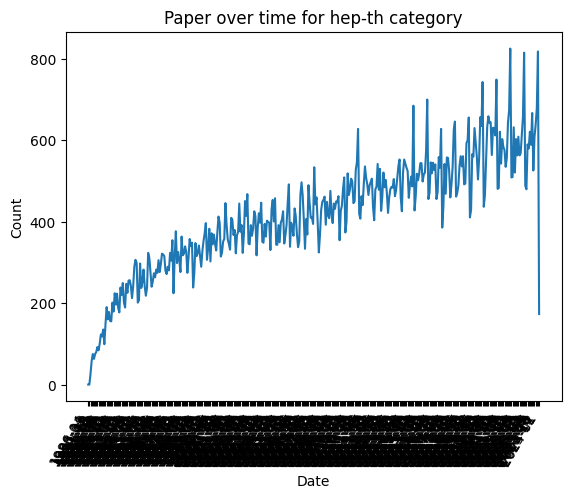

In [65]:
def show_papers_over_time(category, df):
  # extract creation date
  convert_data_f = udf(convert_data, StringType())
  modified_df = df.withColumn('createDate', convert_data_f(df.versions[0]['created']))

  modified_df = filter_by_category(modified_df, category)
  modified_df = modified_df.groupBy('createDate').count().orderBy(asc('createDate'))
  create_graph(modified_df, category)

show_papers_over_time('hep-th', arxiv_dataset)

### **Cluster and top words**

In [10]:
def tokenize_dataset(dataset, input_col, output_col):
  tokenizer = Tokenizer(inputCol=input_col, outputCol=output_col)
  return tokenizer.transform(dataset)

def vectorize_dataset(dataset, input_col, output_col):
  dataset = remove_extra_spaces(dataset, "categories")
  words2vec_model = Word2Vec(inputCol="words",
                             outputCol=output_col,
                             vectorSize=100,
                             minCount=1)
  return words2vec_model.fit(tokenize_dataset(dataset, input_col, "words"))

def prepare_data(dataset, output_col='scaled_categories', input_col="categories"):
  scaler = StandardScaler(inputCol="vector",
                          outputCol=output_col,
                          withStd=True,
                          withMean=False)
  model = vectorize_dataset(dataset, input_col, "vector")
  scalerModel = scaler.fit(model.getVectors())
  # data.select('scaled_categories').show(5)
  return scalerModel.transform(model.getVectors())

In [8]:
def show_silhouette_score_graph(dataset):
  silhouette_score = []
  evaluator = ClusteringEvaluator(predictionCol="prediction",
                                  featuresCol='scaled_categories',
                                  metricName='silhouette',
                                  distanceMeasure='squaredEuclidean')
  dataset = prepare_data(dataset)
  for i in range(2,10):
    kmeans=KMeans(featuresCol='scaled_categories', k=i)
    model=kmeans.fit(dataset)
    predictions=model.transform(dataset)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

  # Choose k = 4
  plt.plot(range(2,10),silhouette_score)
  plt.xlabel('k')
  plt.ylabel('silhouette score')
  plt.title('Silhouette Score')
  plt.show()

In [11]:
def create_clusters(dataset, k_value):
  kmeans = KMeans(featuresCol='scaled_categories', k=k_value)
  return kmeans.fit(prepare_data(dataset))

def create_predictions(model, dataset):
  return model.transform(prepare_data(dataset))

24/01/18 20:14:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette Score for k = 2 is 0.9185531368348404
Silhouette Score for k = 3 is 0.8743340086579036
Silhouette Score for k = 4 is 0.78889854140538
Silhouette Score for k = 5 is 0.368740166610696
Silhouette Score for k = 6 is 0.6842677435903859
Silhouette Score for k = 7 is 0.7799692617910211
Silhouette Score for k = 8 is 0.709313032682638
Silhouette Score for k = 9 is 0.7759211778165903


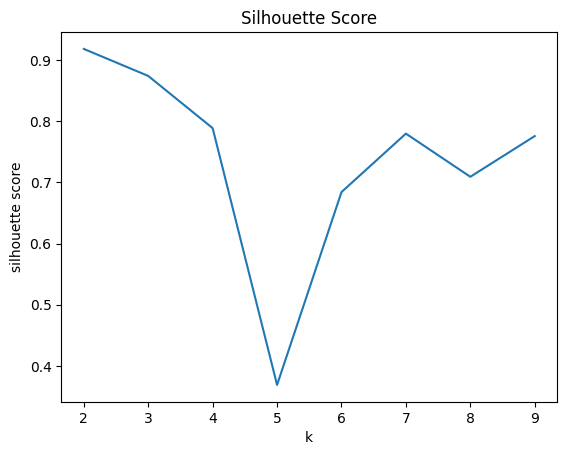

Cluster Centers: 
[-0.34261504  0.22218171 -0.188369   -0.31235113 -0.13713161 -0.15171259
  0.00742106  0.07601832  0.0461024   0.10991912  0.2329148  -0.26980997
  0.25160821  0.06346483 -0.07301384 -0.06614036  0.04321602  0.01354296
 -0.03342347 -0.05075265 -0.04382348 -0.2966513  -0.2120222  -0.31108283
  0.01087753 -0.03750378  0.26250575  0.16955519  0.42578045 -0.25637272
 -0.16867745 -0.10285955  0.00442953  0.05551814 -0.17929239 -0.08945747
  0.24194792 -0.0272858   0.17764543 -0.02222575  0.10020325  0.24173763
 -0.21180483 -0.29754857  0.03212211  0.29025862  0.11880024 -0.31761733
  0.34743851  0.11978588 -0.07860813 -0.03007619 -0.24421023 -0.16371925
 -0.15193923 -0.3283295   0.25616141 -0.24623748  0.20010267 -0.35129188
 -0.28779838 -0.11966179  0.1818871   0.08359199  0.31126209  0.06632467
  0.07136405 -0.1090537   0.13627848  0.39184664 -0.14047987  0.05179581
  0.23498243 -0.265085    0.0632679  -0.29156635 -0.12547104 -0.31786982
 -0.18935154 -0.22031463  0.04072

In [12]:
def run():
  arxiv_dataset = load_data_from_json(sc, "/home/ubuntu/data/arxiv-sample.json")
  show_silhouette_score_graph(arxiv_dataset)

  model = create_clusters(arxiv_dataset, 4)
  print("Cluster Centers: ")
  for center in model.clusterCenters():
    print(center)

  create_predictions(model, arxiv_dataset).select('prediction').show(10)

run()

In [13]:
def prepare_dataset(dataset):
  dataset = remove_empty_fields(dataset, "abstract")
  dataset = remove_empty_newlines(dataset, "abstract")
  dataset = remove_math_formula(dataset, "abstract")
  dataset = convert_to_lowercase(dataset, "abstract")
  dataset = remove_extra_spaces(dataset, "abstract")
  return dataset

In [14]:
def show_word_cloud(dataset, category):
  text =  " ".join(dataset.filter(dataset.categories.contains(category)).select("abstract").rdd.flatMap(lambda x: x).collect())
  wordcloud = WordCloud().generate(text)

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [15]:
def show_word_top(dataset, category, count):
  dataset = remove_stop_words(dataset, "abstract", "filtered_abstract", list(STOPWORDS))
  dataset = dataset.filter(dataset.categories.contains(category))
  dataset = dataset.withColumn('filtered_abstract', explode(split('filtered_abstract', ' '))).groupBy('filtered_abstract').count().orderBy(desc('count'))
  top_val_dict = {r['filtered_abstract']:r['count'] for r in dataset.head(count)}
  top_val_dict.pop("")
  print(top_val_dict)


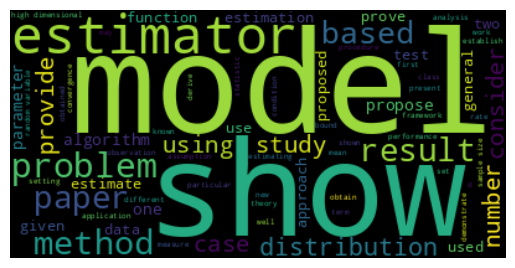

{'model': 9493, 'data': 9392, 'show': 8309, 'distribution': 8145, 'results': 8087, 'random': 7390, 'estimator': 7127, 'based': 7050, 'estimation': 6960}


In [16]:
def run():
  arxiv_dataset = load_data_from_json(sc, PATH)
  show_word_cloud(arxiv_dataset, "stat.TH")
  show_word_top(arxiv_dataset, "stat.TH", 10)

run()

## **Prolific authors**

### **Article categories**

In [10]:
arxiv_dataset = load_data_from_json(sc, PATH)
categories_df = arxiv_dataset.select("categories")
distinct_categories_df = categories_df.distinct()
categories_list = distinct_categories_df.rdd.flatMap(lambda x: x).collect()

for i in range(len(categories_list)):
    element = categories_list[i]
    categories = element.split()
    categories_list[i] = categories

categories_list = set([item for sublist in categories_list for item in sublist])

print(categories_list)

{'stat.CO', 'q-bio.TO', 'math.RT', 'cs.DS', 'q-fin.TR', 'physics.hist-ph', 'q-bio.PE', 'stat.OT', 'eess.IV', 'cond-mat.soft', 'cs.DB', 'cs.DM', 'physics.atm-clus', 'cond-mat.dis-nn', 'cs.GR', 'math.HO', 'astro-ph.GA', 'stat.AP', 'math.CO', 'math.LO', 'physics.ao-ph', 'cs.OH', 'ao-sci', 'cs.CR', 'physics.data-an', 'physics.acc-ph', 'physics.atom-ph', 'gr-qc', 'eess.SY', 'cond-mat.mes-hall', 'eess.SP', 'physics.optics', 'math.PR', 'physics.geo-ph', 'econ.TH', 'astro-ph.IM', 'physics.ins-det', 'math.NA', 'physics.med-ph', 'cs.RO', 'math.CV', 'math.GR', 'cs.GL', 'nucl-th', 'q-fin.ST', 'cond-mat.mtrl-sci', 'acc-phys', 'cs.LG', 'math.SG', 'physics.app-ph', 'math.MP', 'math.CA', 'math.OA', 'math.IT', 'cs.SE', 'cs.IR', 'cs.DC', 'cs.CG', 'math.AT', 'nlin.SI', 'q-bio', 'physics.gen-ph', 'cs.PL', 'cs.SY', 'cs.AI', 'stat.ME', 'physics.bio-ph', 'nlin.PS', 'cs.CC', 'solv-int', 'cs.NA', 'math.DG', 'hep-ex', 'q-fin.RM', 'nlin.AO', 'math.FA', 'math.MG', 'adap-org', 'stat.TH', 'comp-gas', 'cs.MS', 'cs.M

### **Articles authors**

In [9]:
arxiv_dataset = arxiv_dataset.withColumn("authors_list", get_authors_list("authors_parsed"))

authors_df = arxiv_dataset.select("authors")
distinct_authors_df = authors_df.distinct()
authors_list = distinct_authors_df.rdd.flatMap(lambda x: x).collect()

authors = arxiv_dataset.select("authors_list")
authors = (
    authors.rdd.map(lambda x: x.authors_list)
    .map(lambda x: [item for item in x])
    .flatMap(lambda x: x)
    .distinct()
)

print("Number of authors: ", authors.count())

Number of authors:  1568947


In [17]:
authors.collect()[:10]

['Law C. K.',
 'Shu Zhan',
 'Hergenrother C. W.',
 'Brejová Broňa',
 'Fouxon Itzhak',
 'Leach P. G. L.',
 'Tacconi L. J.',
 'Martin A. M.',
 'Gu Bo',
 'Brink D. M.']

### **Find prolific authors for a specific category**

In [ ]:
for category in categories_list:
  filtered_df = arxiv_dataset.filter(col("categories").like(f"%{category}%"))
  authors_per_category = filtered_df.select("authors_parsed").distinct().rdd.flatMap(lambda x: x).collect()

  prolific_authors = {}
  for author_list in authors_per_category:
      for author in author_list:
          author_name = author[0] + ' ' + author[1]
          prolific_authors[author_name] = prolific_authors.get(author_name,0) + 1
      
  max_author = max(prolific_authors, key=prolific_authors.get)
  print("Category: " + category + " Author: " + str(max_author))


Category: stat.CO Author: Jasra Ajay


Category: q-bio.TO Author: Iber Dagmar


Category: math.RT Author: Futorny Vyacheslav


Category: cs.DS Author: Woodruff David P.


Category: q-fin.TR Author: Lillo Fabrizio


Category: physics.hist-ph Author: Hamacher Duane W.


Category: q-bio.PE Author: Perc Matjaz


Category: stat.OT Author: Horton Nicholas J.


Category: eess.IV Author: Maier Andreas


Category: cond-mat.soft Author: Löwen Hartmut


Category: cs.DB Author: Darmont Jérôme


Category: cs.DM Author: Shallit Jeffrey


Category: physics.atm-clus Author: Küpper Jochen


Category: cond-mat.dis-nn Author: Parisi Giorgio


Category: cs.GR Author: Cohen-Or Daniel


Category: math.HO Author: Katz Mikhail G.


Category: astro-ph.GA Author: Menten K. M.


Category: stat.AP Author: Small Dylan S.


Category: math.CO Author: Sudakov Benny


Category: math.LO Author: Shelah Saharon


Category: physics.ao-ph Author: Lucarini Valerio


Category: cs.OH Author: Troccaz Jocelyne


Category: ao-sci Author: Griffies Stephen M.


Category: cs.CR Author: Conti Mauro


Category: physics.data-an Author: Zhou Tao


Category: physics.acc-ph Author: Nagaitsev S.


Category: physics.atom-ph Author: Flambaum V. V.


Category: gr-qc Author: Cardoso Vitor


Category: eess.SY Author: Ames Aaron D.


Category: cond-mat.mes-hall Author: Taniguchi Takashi


Category: eess.SP Author: Eldar Yonina C.


Category: physics.optics Author: Malomed Boris A.


Category: math.PR Author: Peres Yuval


Category: physics.geo-ph Author: Lucarini Valerio


Category: econ.TH Author: Tamuz Omer


Category: astro-ph.IM Author: Guyon Olivier


Category: physics.ins-det Author: Weber M.


Category: math.NA Author: Rozza Gianluigi


Category: physics.med-ph Author: Payan Yohan


Category: cs.RO Author: Levine Sergey


Category: math.CV Author: Ponnusamy Saminathan


Category: math.GR Author: Praeger Cheryl E.


Category: cs.GL Author: Dodig-Crnkovic Gordana


Category: nucl-th Author: Meißner Ulf-G.


Category: q-fin.ST Author: Zhou Wei-Xing


Category: cond-mat.mtrl-sci Author: Taniguchi Takashi


Category: acc-phys Author: Kurennoy Sergey S.


Category: cs.LG Author: Bengio Yoshua


Category: math.SG Author: Miranda Eva


Category: physics.app-ph Author: Taniguchi Takashi


Category: math.MP Author: Exner Pavel


Category: math.CA Author: Yang Dachun


Category: math.OA Author: Sims Aidan


Category: math.IT Author: Poor H. Vincent


Category: cs.SE Author: Lo David


Category: cs.IR Author: de Rijke Maarten


Category: cs.DC Author: Buyya Rajkumar


Category: cs.CG Author: Demaine Erik D.


Category: math.AT Author: Masuda Mikiya


Category: nlin.SI Author: Lakshmanan M.


Category: q-bio Author: Bassett Danielle S.


Category: physics.gen-ph Author: Jamil Mubasher


Category: cs.PL Author: Yoshida Nobuko


Category: cs.SY Author: Lygeros John


Category: cs.AI Author: Levine Sergey


Category: stat.ME Author: Fan Jianqing


Category: physics.bio-ph Author: Lauga Eric


Category: nlin.PS Author: Kevrekidis P. G.


Category: cs.CC Author: Demaine Erik D.


Category: solv-int Author: Ramani A.


Category: cs.NA Author: Rozza Gianluigi


Category: math.DG Author: Biswas Indranil
